In [4]:
import os
import torch
import pickle

import gym
import bayes_opt
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from torch.distributions.multivariate_normal import MultivariateNormal

from pendulum.rl import load_from_path
from stitching.rl import (
    PolicyCollection,
    StateActionFunction,
    ValueFunction,
    PopTart,
    LatentMapping,
    LatentWrapped,
    ReplayBuffer,
    soft_update,
    Policy)

## Create an array of policies to gather data from

In [5]:
def get_envs(base_path):
    envs = PolicyCollection()

    for folder in sorted(os.listdir(base_path)):
        if not os.path.isdir(os.path.join(base_path, folder)):
            continue
        path = os.path.join(base_path, folder, 'policy.pkl')
        envs.append(*load_from_path(path))
        
    return envs
    
envs = get_envs('../pendulum/trained_agents4/')
envs_test = get_envs('../pendulum/trained_agents4_test/')

envs.reset()
envs_test.reset()
buffer_capacity = 1000000
buffer = ReplayBuffer(buffer_capacity)
dataloader = DataLoader(buffer, batch_size=500, shuffle=True, drop_last=True)

val_size = 500
buffer_val = ReplayBuffer(val_size)
dataloader_val = DataLoader(buffer_val, batch_size=val_size)

In [3]:
with open('../pendulum/trained_agents4/data_init_val.pkl', 'rb') as f:
    buffer_val = pickle.load(f)
with open('../pendulum/trained_agents4/data_init.pkl', 'rb') as f:
    buffer = pickle.load(f)
with open('../pendulum/trained_agents4/data_init_test.pkl', 'rb') as f:
    buffer_test = pickle.load(f)
dataloader = DataLoader(buffer, batch_size=32, shuffle=True, drop_last=True)
dataloader_val = DataLoader(buffer, batch_size=val_size)
dataloader_test = DataLoader(buffer_test, batch_size=32)

In [13]:
from datetime import datetime
from datetime import timedelta

delta = timedelta(seconds=30.0)
next_print = datetime.now() + delta

while len(buffer) < buffer_capacity:
    if datetime.now() > next_print:
        print(f'{100 * len(buffer) / buffer_capacity:.0f}% done: {len(buffer)}')
        next_print = datetime.now() + delta
    buffer.extend(envs.step(epsilon=0.5))

0% done: 4043
1% done: 6723
1% done: 9403
1% done: 12083
1% done: 14763
2% done: 17403
2% done: 20043
2% done: 22643
3% done: 25283
3% done: 27963
3% done: 30603
3% done: 33243
4% done: 35923
4% done: 38603
4% done: 41243
4% done: 43923
5% done: 46563
5% done: 49163
5% done: 51803
5% done: 54403
6% done: 57003
6% done: 59643
6% done: 62283
6% done: 64923
7% done: 67523
7% done: 70203
7% done: 72883
8% done: 75563
8% done: 78203
8% done: 80883
8% done: 83523
9% done: 86203
9% done: 88883
9% done: 91563
9% done: 94203
10% done: 96883
10% done: 99563
10% done: 102243
10% done: 104923
11% done: 107603
11% done: 110283
11% done: 112963
12% done: 115643
12% done: 118323
12% done: 121003
12% done: 123683
13% done: 126363
13% done: 129043
13% done: 131723
13% done: 134403
14% done: 137083
14% done: 139763
14% done: 142443
15% done: 145083
15% done: 147723
15% done: 150403
15% done: 153083
16% done: 155763
16% done: 158403
16% done: 161083
16% done: 163763
17% done: 166443
17% done: 169083
17% 

In [171]:
from datetime import datetime
from datetime import timedelta

delta = timedelta(seconds=10.0)
next_print = datetime.now() + delta

test_size = 20 * 200 * 4
buffer_test = ReplayBuffer(test_size)
dataloader_test = DataLoader(buffer_test, batch_size=32)

while len(buffer_test) < test_size:
    if datetime.now() > next_print:
        print(f'{100 * len(buffer_test) / test_size:.0f}% done: {len(buffer_test)}')
        next_print = datetime.now() + delta
    buffer_test.extend(envs_test.step(epsilon=0.5))

5% done: 868
11% done: 1732
16% done: 2592
22% done: 3464
27% done: 4340
33% done: 5212
38% done: 6080
43% done: 6956
49% done: 7824
54% done: 8684
60% done: 9548
65% done: 10416
70% done: 11276
76% done: 12140
81% done: 13008
87% done: 13872
92% done: 14740
98% done: 15608


In [13]:
from datetime import datetime
from datetime import timedelta

delta = timedelta(seconds=30.0)
next_print = datetime.now() + delta

envs.reset()

while len(buffer_val) < val_size:
    if datetime.now() > next_print:
        print(f'{100 * len(buffer_val) / val_size:.0f}% done: {len(buffer_val)}')
        next_print = datetime.now() + delta
    buffer_val.extend(envs.step(epsilon=0.5))

In [185]:
#with open(os.path.join(base_path, 'data_init.pkl'), 'wb') as f:
#    pickle.dump(buffer, f)
#with open(os.path.join(base_path, 'data_init_val.pkl'), 'wb') as f:
#    pickle.dump(buffer_val, f)
with open('../pendulum/trained_agents4/data_init_test.pkl', 'wb') as f:
    pickle.dump(buffer_test, f)

# Preprocessing layer(s)

In [6]:
class PendulumPre(torch.nn.Module):

    def forward(self, x):
        x_ = torch.zeros(x.size(0), x.size(1) + 1)
        if x.is_cuda:
            x_ = x_.cuda()
        x_[:, -1] = x[:, -1]
        x_[:, 0] = torch.cos(x[:, 0])
        x_[:, 1] = torch.sin(x[:, 0])
        return x_

x_pre = PendulumPre()

## Create all models

In [7]:
x_size = envs.observation_space.shape[0] + 1  # + 1 for pendulum angle preprocessing
u_size = envs.action_space.shape[0]
n_latent = len(envs)
z_size = 8
gamma = 0.99
latent_mapping = LatentMapping(z_size, n_latent)
latent_mapping_target = LatentMapping(z_size, n_latent)

Q = StateActionFunction(x_size, u_size, z_size)
Q_target = StateActionFunction(x_size, u_size, z_size)
norm_q = PopTart(alpha=0.99)

policy = Policy(x_size, u_size, z_size)

def model_params():
    for model in [Q, norm_q]:
        for p in model.parameters():
            yield p

Q_opt = torch.optim.Adam(model_params(), weight_decay=1e-4)
Z_opt = torch.optim.Adam(latent_mapping.parameters())

if torch.cuda.is_available:
    x_pre.cuda()
    Q.cuda()
    latent_mapping.cuda()
    Q_target.cuda()
    latent_mapping_target.cuda()
    norm_q.cuda()
    policy.cuda()
    
logger = SummaryWriter('runs/bug-free-poptart-manual-bootstrap')
logger_val = SummaryWriter('runs/bug-free-poptart-manual-bootstrap-val')

In [8]:
latent_mapping.load_state_dict(torch.load('models/pendulum/latent_mapping.pt'))
latent_mapping_target.load_state_dict(torch.load('models/pendulum/latent_mapping_target.pt'))
Q.load_state_dict(torch.load('models/pendulum/Q.pt'))
Q_target.load_state_dict(torch.load('models/pendulum/Q_target.pt'))
norm_q.load_state_dict(torch.load('models/pendulum/norm_q.pt'))

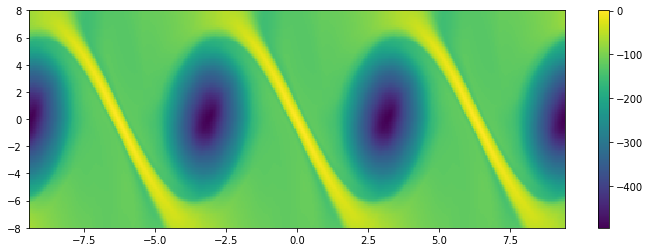

In [9]:
def plot_v(env_id=0, show=False):
    res = 128
    img = np.zeros((res, res))
    x = torch.zeros((res * res, 2)).cuda()
    u = torch.zeros((res * res, 1)).cuda()
    i = torch.zeros((res * res, 1)).long().cuda() + env_id
    for col, theta in enumerate(np.linspace(-np.pi, np.pi, res)):
        for row, thdot in enumerate(np.linspace(-8, 8, res)):
            x[col * res + row, :] = torch.cuda.FloatTensor([[theta, thdot]])
    z, kl = latent_mapping(i, deterministic=True)
    img_flat = norm_q(Q(x_pre(x), u, z)).cpu().detach().numpy()
    img = img_flat.reshape((res, -1)).T
    fig = plt.figure(figsize=(12, 4))
    img = np.tile(img, [1, 3])
    plt.imshow(img, origin='lower', extent=[-3 * np.pi, 3 * np.pi, -8, 8], aspect='auto')
    plt.colorbar()
    if show:
        plt.show()
    else:
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer._renderer)
        plt.close()
        return plot_img

plot_v(env_id=3, show=True)

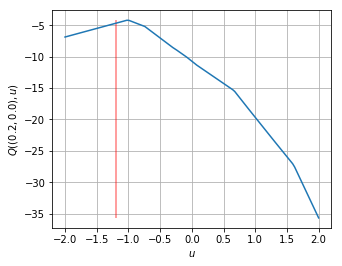

In [104]:
def plot_q(state=[-1.0, 0.0], env_id=0, show=False):
    theta, thetadot = state
    res = 128
    x = torch.cuda.FloatTensor([[theta, thetadot]]).repeat((res, 1))
    x = x_pre(x)
    us = np.linspace(-2, 2, res)
    u = torch.cuda.FloatTensor(us.reshape(-1, 1))
    i = torch.cuda.LongTensor([[env_id]]).repeat(res, 1)
    z, kl = latent_mapping(i, deterministic=True)
    ys = (norm_q(Q(x, u, z))).detach().cpu().numpy().flatten()
    
    #env = envs.envs[env_id].env # wrapped a million times, ugly af
    #xs_ = torch.cuda.FloatTensor([env.forward(state, [u]) for u in us])
    #rs = torch.cuda.FloatTensor([env.reward(state, [u]) for u in us]).reshape(-1, 1)
    #ys_true = rs + gamma * norm_q(Q(x_pre(xs_), z))
    #ys_true = ys_true.detach().cpu().numpy().flatten()
    
    # Policy
    u_policy = policy(x[:1, :], z[:1, :])
    
    fig = plt.figure(figsize=(5, 4))
    plt.plot(us, ys)
    #plt.plot(us, ys_true)
    plt.vlines(u_policy.detach().cpu().numpy(), ys.min(), ys.max(), 'r', alpha=0.5)
    plt.xlabel('$u$')
    plt.ylabel(f'$Q({theta, thetadot}, u)$')
    plt.grid()
    if show:
        plt.show()
    else:
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer._renderer)
        plt.close()
        return plot_img

plot_q(env_id=18, state=[0.2, 0.0], show=True)
env = envs.envs[0].env

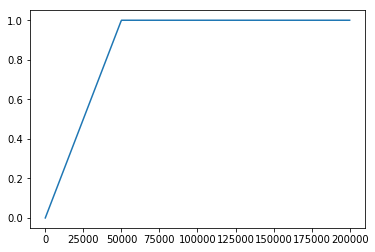

In [61]:
def variational_warmup(iteration, nmin=0, nmax=50000):
    if iteration < nmin:
        return 0.0
    if iteration > nmax:
        return 1.0
    return (iteration - nmin) / (nmax - nmin)

xs = np.linspace(0, 200000, 500)
ys = []
for x in xs:
    ys.append(variational_warmup(x))
plt.plot(xs, ys)
plt.show()

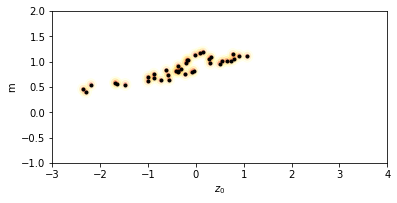

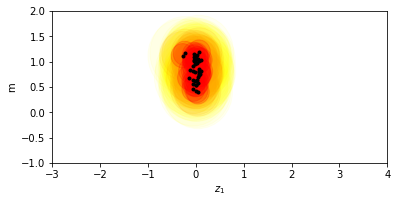

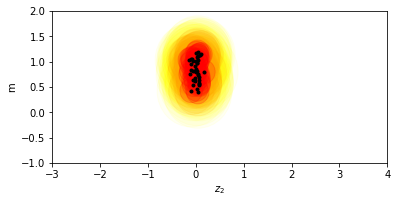

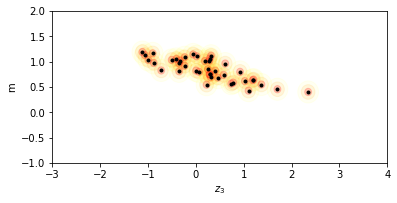

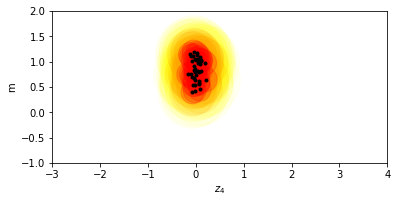

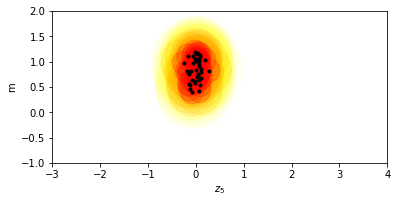

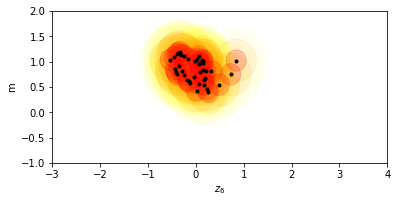

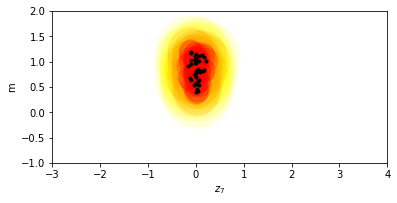

In [6]:
def plot_latent(dim, prop='m', show=False):
    c3s = []
    c2s = []
    c1s = []
    plt.figure(figsize=(6, 2.8))
    p_min = np.inf
    p_max = -np.inf
    for i, env_ in enumerate(envs.envs):
        env = env_.env
        p, µ = (getattr(env, prop), latent_mapping.mean[i, dim].detach().cpu().numpy())
        p_min = min(p_min, p)
        p_max = max(p_max, p)
        σ = np.exp(latent_mapping.std_logits[0, dim].detach().cpu().numpy()) ** 0.5
        plt.plot(µ, p, 'k.')
        c1 = plt.Circle((µ, p), σ * 0.33, fill=True, color='red', alpha=0.2)
        c2 = plt.Circle((µ, p), σ * 0.66, fill=True, color='orange', alpha=0.1)
        c3 = plt.Circle((µ, p), σ * 1.00, fill=True, color='yellow', alpha=0.05)
        c1s.append(c3)
        c2s.append(c2)
        c3s.append(c1)
    for cs in [c1s, c2s, c3s]:
        for artist in cs:
            plt.gca().add_artist(artist)
    plt.ylabel(prop)
    plt.xlabel(f'$z_{dim}$')
    plt.xlim(-3, 4)
    if prop == 'm':
        plt.ylim(-1, 2)
    elif prop == 'action_cost':
        plt.ylim(-0.5, 2.5)
    if show:
        plt.show()
    else:
        fig = plt.gcf()
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer._renderer)
        plt.close()
        return plot_img
for dim in range(8):
    plot_latent(dim, prop='m', show=True)

## Train
### TODO
- Change between different exploration strategies to explore the entire state space
- Sample states uniformly? Would this work with mujoco?

In [63]:
def validate():
    i, x, u, u_opt, r, x_, u_ = next(iter(dataloader_val))
    x = x_pre(x)
    x_ = x_pre(x_)
    if torch.cuda.is_available:
        i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(), (i, x, u, u_opt, r, x_, u_))

    z, kl = latent_mapping(i, deterministic=True)
    v_unnorm = Q_target(x_, u_, z)
    v_ = norm_q(v_unnorm)
    q_target = (r + gamma * v_)
    q_loss = norm_q.mse_loss(Q(x, u, z), q_target.detach())

    log_likelihood = -10.0 * q_loss
    elbo = log_likelihood - 0.001 * kl.mean()
    return elbo

In [ ]:
Q.train()
norm_q.train()
latent_mapping.train()

r_max = -np.inf
r_min = np.inf
best_val = -np.inf

n_steps = -1
while True:
    for i, x, u, u_opt, r, x_, u_ in dataloader:
        n_steps += 1
        
        r_min = min(r_min, r.min())
        r_max = max(r_max, r.max())
        
        # Manual bootstrap
        x[-1] *= 0
        u[-1] *= 0
        r[-1] *= 0
        x_[-1] *= 0
        u_[-1] *= 0
        
        # Data admin
        x = x_pre(x)
        x_ = x_pre(x_)
        if torch.cuda.is_available:
            i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(), (i, x, u, u_opt, r, x_, u_))
        
        # Targets
        z_rand, kl = latent_mapping(i)
        z_det, _ = latent_mapping(i, deterministic=True)
        v_unnorm = Q_target(x_, u_, z_det)
        v_ = norm_q(v_unnorm)
        q_target = (r + gamma * v_).clamp(r_min / (1 - gamma), r_max / (1 - gamma))
        # Manual bootstrap
        q_target[-1] *= 0
        q_loss = norm_q.mse_loss(Q(x, u, z_rand), q_target.detach())

        log_likelihood = -10.0 * q_loss
        elbo = log_likelihood - 0.001 * variational_warmup(n_steps) * kl.mean()
        
        Q_opt.zero_grad()
        Z_opt.zero_grad()
        (-elbo).backward()
        Q_opt.step()
        Z_opt.step()
        
        soft_update(Q_target, Q, 0.001)
        soft_update(latent_mapping_target, latent_mapping, 0.001)
        
        if n_steps % 1000 == 0:
            logger.add_image('v_3', plot_v(env_id=3), n_steps)
            logger.add_image('v_4', plot_v(env_id=4), n_steps)
            logger.add_image('q_0', plot_q(state=[0.0, 0.0]), n_steps)
            logger.add_image('q_1', plot_q(state=[0.6, 0.0]), n_steps)
            logger.add_image('q_-1', plot_q(state=[-0.6, 0.0]), n_steps)
            for i in range(z_size):
                logger.add_image(f'latent_{i}_m', plot_latent(i, prop='m'), n_steps)
            for i in range(z_size):
                logger.add_image(f'latent_{i}_ac', plot_latent(i, prop='action_cost'), n_steps)
        if n_steps % 100 == 0:
            grad_norm = 0.0
            for param in Q.parameters():
                grad_norm += param.grad.norm()
            logger.add_scalar('v_mean', v_unnorm.mean(), n_steps)
            logger.add_scalar('grad_norm', grad_norm, n_steps)
            logger.add_scalar('kl', kl.mean(), n_steps)
            logger.add_scalar('ll', log_likelihood, n_steps)
            logger.add_scalar('vσ', norm_q.σ, n_steps)
            logger.add_scalar('vµ', norm_q.µ, n_steps)
            logger.add_scalar('elbo', elbo, n_steps)
            val = validate()
            logger_val.add_scalar('elbo', val, n_steps)
            if val > best_val:
                best_val = val
                torch.save(latent_mapping.state_dict(), 'models/pendulum/latent_mapping.pt')
                torch.save(latent_mapping_target.state_dict(), 'models/pendulum/latent_mapping_target.pt')
                torch.save(norm_q.state_dict(), 'models/pendulum/norm_q.pt')
                torch.save(Q.state_dict(), 'models/pendulum/Q.pt')
                torch.save(Q_target.state_dict(), 'models/pendulum/Q_target.pt')
        if n_steps >= 500000:
            break
    if n_steps >= 500000:
        break

# Train latent space for test environments

In [24]:
#latent_mapping_test = LatentMapping(z_size, len(envs_test)).cuda()
#Q.eval()
#Q_target.eval()
#norm_q.eval()
#latent_mapping_test.train()
#
#Z_opt_test = torch.optim.Adam(latent_mapping_test.parameters())
#
#n_steps = -1
while True:
    for i, x, u, u_opt, r, x_, u_ in dataloader_test:
        n_steps += 1
        
        # Data admin
        x = x_pre(x)
        x_ = x_pre(x_)
        if torch.cuda.is_available:
            i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(), (i, x, u, u_opt, r, x_, u_))
        
        # Targets
        z_det, kl = latent_mapping_test(i, deterministic=True)
        z_rand, kl = latent_mapping_test(i, deterministic=False)
        v_unnorm = Q_target(x_, u_, z_det)
        v_ = norm_q(v_unnorm)
        q_target = (r + gamma * v_)
        q_loss = norm_q.mse_loss(Q(x, u, z_rand), q_target.detach())

        log_likelihood = -10.0 * q_loss
        elbo = log_likelihood - 0.001 * kl.mean()
        
        Z_opt_test.zero_grad()
        (-elbo).backward()
        Z_opt_test.step()
        
        if n_steps % 8000 == 0:
            print(log_likelihood.cpu().detach().numpy())
        if n_steps % 80000 == 0:
            print(latent_mapping_test.mean)
            print(latent_mapping_test.std_logits)
        if n_steps >= 500000:
            break
    if n_steps >= 500000:
        break

-0.0077281496
-0.0060660294
Parameter containing:
tensor([[ 1.2894,  0.4802, -0.4576, -0.4449,  0.3809, -0.3303,  0.3776,
         -0.2481],
        [-0.9256, -0.1857,  0.2271,  1.0214, -0.0299,  0.2456, -0.2370,
          0.1631],
        [ 1.4041,  0.7884, -0.1165,  0.3036,  0.1113, -0.3543,  0.3072,
         -0.1885],
        [-1.1734, -0.5643,  0.2734,  0.8447, -0.1506,  0.1914, -0.3892,
          0.4054]], device='cuda:0')
Parameter containing:
tensor([[-4.1496, -0.7000, -0.3945, -2.7887, -0.8621, -0.2942, -0.8397,
         -0.9925]], device='cuda:0')
-0.004815007
-0.0047195745
-0.006087587
-0.006318162
-0.005005207
-0.005786785
-0.0060102995
-0.0042935074
-0.0047050174
-0.005354698
Parameter containing:
tensor([[ 1.3066,  0.4857, -0.4522, -0.4323,  0.3911, -0.2954,  0.3759,
         -0.2371],
        [-0.9177, -0.1669,  0.1916,  1.0020, -0.0311,  0.2217, -0.2191,
          0.1679],
        [ 1.2968,  0.7443, -0.0808,  0.5288,  0.0782, -0.1765,  0.3395,
         -0.0775],
        

KeyboardInterrupt: 

In [25]:
n_steps

295187

In [599]:
logger = SummaryWriter('runs/policy_training')

policy = Policy(x_size, u_size, z_size)
w_init = (torch.rand(policy.fcy.weight.size()) * 6 - 3) * 1e-3
policy.fcy.weight.data.copy_(w_init)
policy.fcy.bias.data *= 0

Q.eval()
latent_mapping.eval()
policy.cuda()
policy.train()
policy_opt = torch.optim.Adam(policy.parameters())

n_steps = -1
while True:
    for i, x, u, u_opt, r, x_, u_ in dataloader:
        n_steps += 1
        
        # Data admin
        x = x_pre(x)
        x_ = x_pre(x_)
        if torch.cuda.is_available:
            i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(), (i, x, u, u_opt, r, x_, u_))
            
        z_rand, kl = latent_mapping(i)
        u_policy = policy(x, z_rand)
        policy_loss = -norm_q(Q_target(x, u_policy, z_rand)).mean()
        policy_opt.zero_grad()
        policy_loss.backward()
        policy_opt.step()
        if n_steps % 1000 == 0:
            logger.add_image('q_0', plot_q(state=[0.0, 0.0]), n_steps)
            logger.add_image('q_1', plot_q(state=[0.6, 0.0]), n_steps)
            logger.add_image('q_-1', plot_q(state=[-0.6, 0.0]), n_steps)
        if n_steps % 100 == 0:
            logger.add_scalar('policy_loss', policy_loss, n_steps)
        if n_steps >= 100000:
            break
    if n_steps >= 100000:
        break
torch.save(policy.state_dict(), 'models/pendulum/policy.pt')

In [29]:
policy.load_state_dict(torch.load('models/pendulum/policy.pt'))

Adaptable: False, mean: -337.73338964798387
Adaptable: True, mean: -341.73221940348105


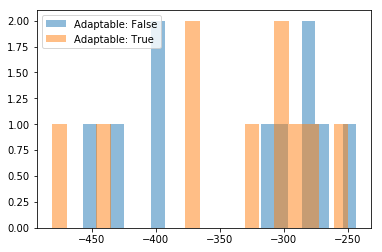

In [133]:
for adaptable in [False, True]:
    n_trials = 10
    avgs = []
    for trial in range(n_trials):
        env_id = np.random.randint(24)
        env = envs.envs[env_id]
        x = env.reset()
        x = env.env.state = np.array([np.pi, 0.0])
        i = torch.cuda.LongTensor([env_id])
        θs = []
        vs = []
        rs = []
        for t in range(200):
            x = x_pre(torch.cuda.FloatTensor(x.reshape(1, -1)))
            z, kl = latent_mapping(i, deterministic=True)
            if not adaptable:
                z *= 0.0
            u = policy(x, z)
            u_np = u.detach().cpu().numpy().flatten()
            x_, r, _, _ = env.step(u_np)
            x = x_
            θs.append(x[0])
            vs.append(x[1])
            rs.append(gamma ** t * r)
        #plt.plot(np.cos(θs) * vs, np.sin(θs) * vs)
        avgs.append(sum(rs))
    print(f'Adaptable: {adaptable}, mean: {sum(avgs) / len(avgs)}')
    plt.hist(avgs, alpha=0.5, bins=20, label=f'Adaptable: {adaptable}')
plt.legend()
#plt.xlim(-8, 8)
#plt.ylim(-8, 8)
plt.show()

-2.0


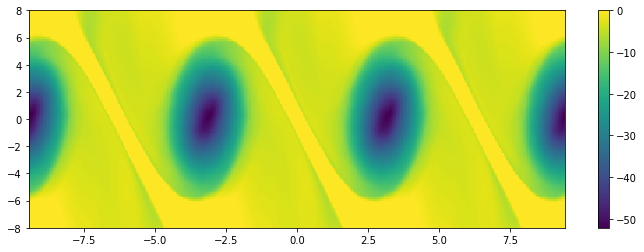

-1.7333333333333334


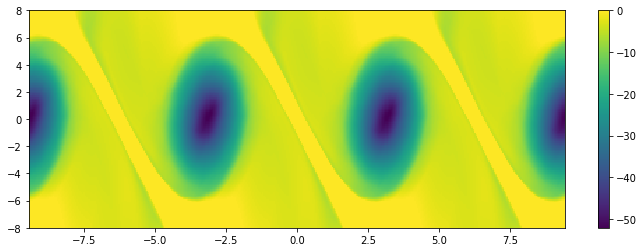

-1.4666666666666668


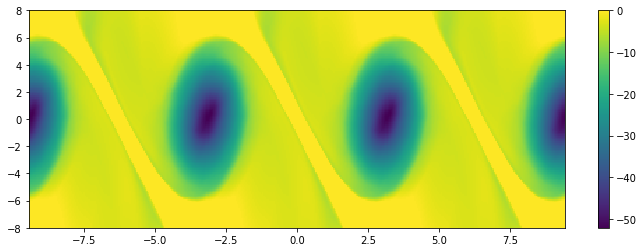

-1.2


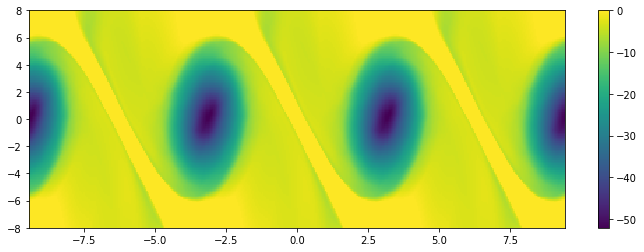

-0.9333333333333333


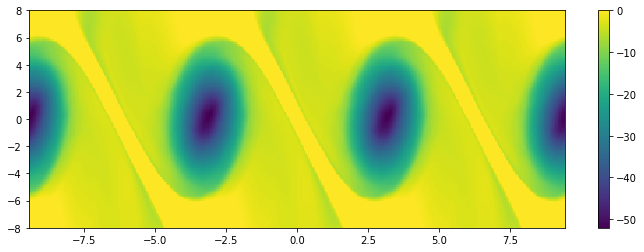

-0.6666666666666667


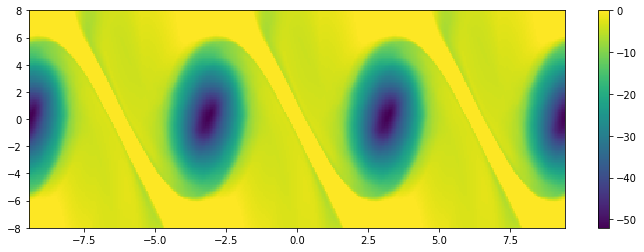

-0.3999999999999999


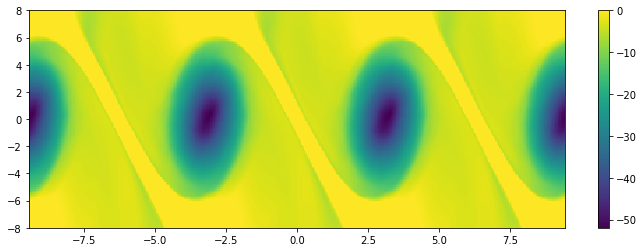

-0.1333333333333333


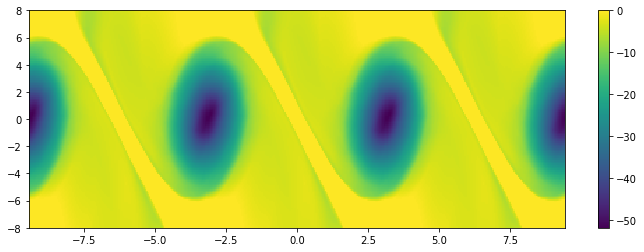

0.1333333333333333


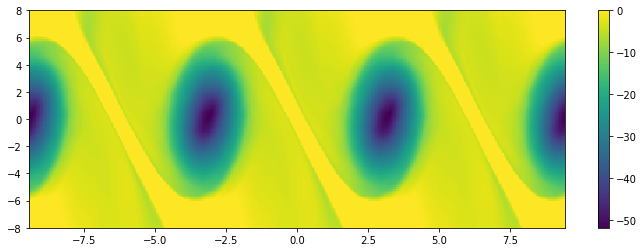

0.3999999999999999


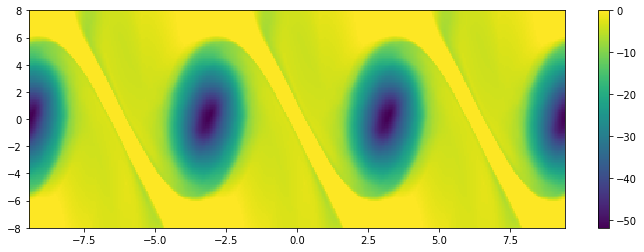

0.6666666666666665


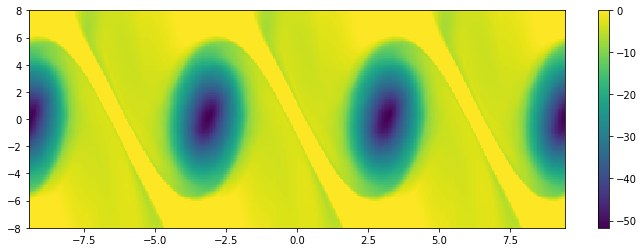

0.9333333333333331


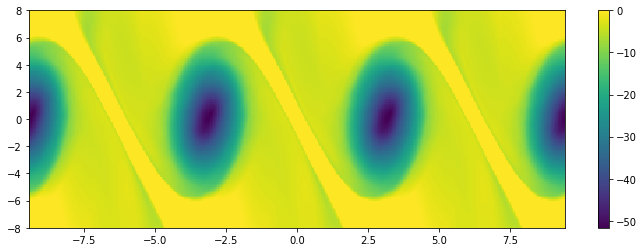

1.2000000000000002


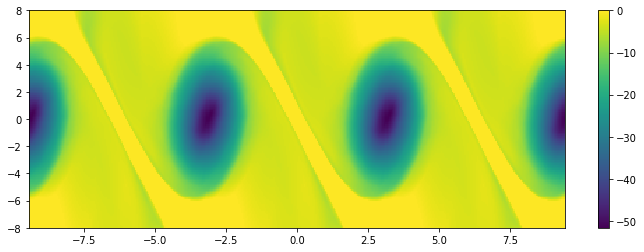

1.4666666666666668


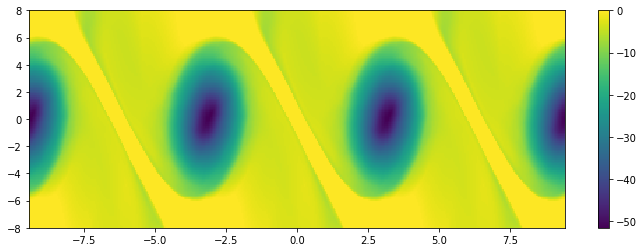

1.7333333333333334


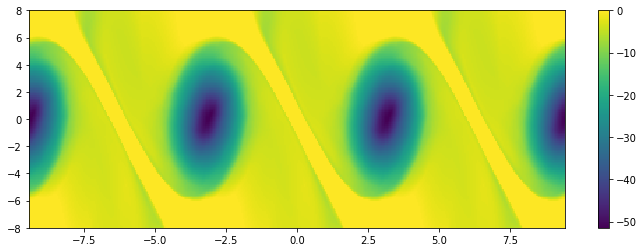

2.0


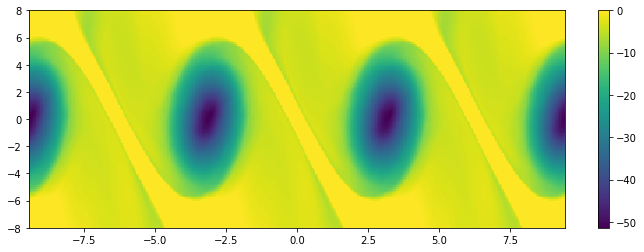

In [55]:
def plot_vz(z, z_dim=0, env_id=0, show=False):
    res = 128
    img = np.zeros((res, res))
    x = torch.zeros((res * res, 2)).cuda()
    u = torch.zeros((res * res, 1)).cuda()
    for col, theta in enumerate(np.linspace(-np.pi, np.pi, res)):
        for row, thdot in enumerate(np.linspace(-8, 8, res)):
            x[col * res + row, :] = torch.cuda.FloatTensor([[theta, thdot]])
    img_flat = Q(x_pre(x), u, z).cpu().detach().numpy()
    img = img_flat.reshape((res, -1)).T
    fig = plt.figure(figsize=(12, 4))
    img = np.tile(img, [1, 3])
    plt.imshow(img, origin='lower', extent=[-3 * np.pi, 3 * np.pi, -8, 8], aspect='auto', vmax=0)
    plt.colorbar()
    if show:
        plt.show()
        
plt.close()
for i in np.linspace(0, 1, 10):
    print(zv)

In [30]:
def evaluate(z1, z2, envs, env_index, use_optimal_policy=False, integrate_z=False, n_trials=16, rollout_len=200, render=False):
    if use_optimal_policy and integrate_z:
        raise ValueError('Cannot integrate over z when using teacher policy!')
    env = envs.envs[env_index]
    optimal_policy = envs.policies[env_index]
    z = np.zeros(8)
    z[0] = z1
    z[3] = z2
    z = torch.cuda.FloatTensor(z.reshape(1, -1))
    Rs = []
    np.random.seed(1)
    for _ in range(n_trials):
        if integrate_z:
            z = torch.randn(1, z_size).cuda()
        env.reset()
        obs = env.env.state = (2 * np.random.rand(2) - 1) * np.array([np.pi, 8.0])
        
        R = 0.0
        for t in range(rollout_len):
            x = x_pre(torch.cuda.FloatTensor(obs.reshape(1, -1))).cuda()
            if use_optimal_policy:
                u_np = optimal_policy.act(obs)
            else:
                u = policy(x, z)
                u_np = u.detach().cpu().numpy().flatten()
            obs, r, _, _ = env.step(u_np)
            R += r * gamma ** t

        Rs.append(R)
    return np.mean(Rs), np.std(Rs) / np.sqrt(n_trials)
    
z1 = 4 * np.random.rand() - 2
z2 = 4 * np.random.rand() - 2
#int_z = evaluate(z1, z2, envs_test, 3, use_optimal_policy=False, n_trials=32, integrate_z=True)
#optimal = evaluate(z1, z2, envs_test, 3, use_optimal_policy=True, n_trials=32, integrate_z=False)
#z1, z2 = bo.res['max']['max_params'].values()
#bo_return = evaluate(z1, z2, envs_test, 3, use_optimal_policy=False, integrate_z=False)
#int_z, optimal, bo_return

In [33]:
for env_index in range(4):
    print(f'Environment: {env_index}')
    # Found latent parameters (GD)
    val_trials = 1000
    z1, z2 = latent_mapping_test.mean[env_index, [0, 3]].cpu().detach().numpy()
    print('Evaluating gradient descent', end=' ')
    gd_µ, gd_σ = evaluate(z1, z2, envs, env_index, use_optimal_policy=False, n_trials=val_trials, integrate_z=False)
    print(gd_µ - 1.96 * gd_σ, gd_µ + 1.96 * gd_σ)
    
    print('Evaluating average policy', end=' ')
    int_z_µ, int_z_σ = evaluate(0, 0, envs, env_index, n_trials=val_trials, integrate_z=True)
    print(int_z_µ - 1.96 * int_z_σ, int_z_µ + 1.96 * int_z_σ)
    
    print('Evaluating teacher policy', end=' ')
    optimal_µ, optimal_σ = evaluate(0, 0, envs, env_index, use_optimal_policy=True, n_trials=val_trials, integrate_z=False)
    print(optimal_µ - 1.96 * optimal_σ, optimal_µ + 1.96 * optimal_σ)
    
    bo = bayes_opt.BayesianOptimization(lambda z1, z2: evaluate(z1, z2, envs, env_index, n_trials=4)[0],
                                        {'z1': (-2, 2), 'z2': (-2, 2)})
    bo.maximize(init_points=5, n_iter=15, **{'alpha': 1e-3})
    z1, z2 = bo.res['max']['max_params'].values()
    bo_return_µ, bo_return_σ = evaluate(z1, z2, envs, env_index, use_optimal_policy=False, n_trials=val_trials, integrate_z=False)
    print(f'Average policy: {int_z_µ:.1f} +- {int_z_σ:.1f}\n' +
          f'Teacher policy: {optimal_µ:.1f} +- {optimal_σ:.1f}\n' +
          f'Gradient descent: {gd_µ:.1f} +- {gd_σ:.1f}\n' +
          f'20-step BO: {bo_return_µ:.1f} +- {bo_return_σ:.1f}')

Environment: 0
Evaluating gradient descent -108.47141795157933 -102.33922562375722
Evaluating average policy -140.45818648050587 -128.74261783928168
Evaluating teacher policy -100.35831221519258 -94.07644089885316
Initialization
-----------------------------------------------------
 Step |   Time |      Value |        z1 |        z2 | 
    1 | 00m00s |  -79.28292 |   -0.1911 |    0.8768 | 
    2 | 00m00s | -104.14815 |    1.7029 |    0.3295 | 
    3 | 00m00s |  -79.11912 |   -1.0528 |    1.3181 | 
    4 | 00m00s |  -88.48419 |    0.4031 |   -0.1434 | 
    5 | 00m00s |  -79.34760 |   -0.7106 |    0.5464 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        z1 |        z2 | 
    6 | 00m00s | -526.35685 |   -2.0000 |   -2.0000 | 
    7 | 00m00s | -169.16734 |    2.0000 |   -2.0000 | 
    8 | 00m00s | -108.25483 |    2.0000 |    2.0000 | 
    9 | 00m01s | -132.37131 |   -2.0000 |    2.0000 | 
   10 | 00m01s |  -79.09529 |   -0.7

In [623]:
for env_index in range(4):
    opt_return = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=True)
    print(f'Environment: {env_index}')
    bo = bayes_opt.BayesianOptimization(lambda z1, z2: evaluate(z1, z2, envs_test, env_index),
                                        {'z1': (-2, 2), 'z2': (-2, 2)})
    bo.maximize(init_points=20, n_iter=20, **{'alpha': 1e-3})
    z1, z2 = bo.res['max']['max_params'].values()
    int_z = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=False, n_trials=128, integrate_z=True)
    optimal = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=True, n_trials=128, integrate_z=False)
    bo_return = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=False, n_trials=128, integrate_z=False)
    print(f'Average policy: {int_z} Teacher policy: {optimal} 20-BO: {bo_return}')

Environment: 0
Initialization
-----------------------------------------------------
 Step |   Time |      Value |        z1 |        z2 | 
    1 | 00m02s | -450.09139 |   -1.9331 |   -1.6475 | 
    2 | 00m02s | -140.16428 |    0.5587 |    1.2095 | 
    3 | 00m02s | -135.78367 |    0.1680 |   -0.8602 | 
    4 | 00m02s | -136.39945 |    1.6440 |    1.0934 | 
    5 | 00m02s | -127.61612 |    0.7480 |    0.0187 | 
    6 | 00m02s | -129.51675 |    0.1952 |    0.6667 | 
    7 | 00m02s | -147.84209 |    1.9909 |   -0.9898 | 
    8 | 00m02s | -137.71456 |    0.4478 |    1.1443 | 
    9 | 00m02s | -328.04601 |   -0.9137 |   -1.6755 | 
   10 | 00m02s | -404.58714 |   -1.5526 |    1.5504 | 
   11 | 00m02s | -143.60522 |    1.7609 |   -1.6832 | 
   12 | 00m02s | -144.31257 |    1.8965 |   -0.6264 | 
   13 | 00m02s | -126.72074 |    0.1835 |    0.2135 | 
   14 | 00m02s | -150.30374 |   -0.4243 |    0.7826 | 
   15 | 00m02s | -141.40125 |    1.4220 |   -1.7231 | 
   16 | 00m02s | -364.76461 |   -1.2

/home/isacar/workspace/rl-project/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.004212]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   31 | 00m03s | -125.01434 |    0.4063 |    0.0626 | 
   32 | 00m03s | -125.00542 |    0.4074 |    0.0629 | 
   33 | 00m04s | -124.99738 |    0.4082 |    0.0632 | 
   34 | 00m04s | -124.99023 |    0.4089 |    0.0636 | 
   35 | 00m04s | -124.98350 |    0.4095 |    0.0639 | 
   36 | 00m04s | -124.97681 |    0.4101 |    0.0643 | 
   37 | 00m04s | -124.97025 |    0.4107 |    0.0648 | 
   38 | 00m04s | -124.96375 |    0.4112 |    0.0653 | 
   39 | 00m04s | -124.95672 |    0.4118 |    0.0659 | 
   40 | 00m04s | -124.94967 |    0.4124 |    0.0666 | 
Average policy: -212.7719140573771 Teacher policy: -205.79204727207113 20-BO: -151.49414679064466
Environment: 1
Initialization
-----------------------------------------------------
 Step |   Time |      Value |        z1 |        z2 | 
    1 | 00m02s |  -84.96073 |    0.1536 |    1.7156 | 
    2 | 00m02s |  -92.55288 |    1.1788 |    0.8007 | 
    3 | 00m02s |  -90.20216 |    0.9034 |    0.0279 | 
    4 | 00m02s |  -88.20873 |   -1.5105 |   -0.3

/home/isacar/workspace/rl-project/venv/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.36839294e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   28 | 00m03s |  -73.29450 |   -0.7903 |    0.5515 | 
   29 | 00m03s |  -73.23950 |   -0.7689 |    0.5559 | 
   30 | 00m03s |  -73.21505 |   -0.7578 |    0.5576 | 
   31 | 00m03s |  -73.20274 |   -0.7502 |    0.5583 | 
   32 | 00m03s |  -73.19526 |   -0.7448 |    0.5586 | 
   33 | 00m03s |  -73.18965 |   -0.7407 |    0.5585 | 
   34 | 00m04s |  -73.18841 |   -0.7374 |    0.5581 | 
   35 | 00m03s |  -73.18883 |   -0.7351 |    0.5575 | 
   36 | 00m04s |  -73.18928 |   -0.7338 |    0.5567 | 
   37 | 00m04s |  -73.19161 |   -0.7333 |    0.5552 | 
   38 | 00m04s |  -73.19754 |   -0.7342 |    0.5526 | 
   39 | 00m05s |  -73.16934 |   -0.7317 |    0.5671 | 
   40 | 00m04s |  -73.16349 |   -0.7303 |    0.5700 | 
Average policy: -138.30335717420616 Teacher policy: -115.4847318092433 20-BO: -102.78337929899543
Environment: 2
Initialization
-----------------------------------------------------
 Step |   Time |      Value |        z1 |        z2 | 
    1 | 00m02s | -425.31104 |   -1.1485 |    0.7

In [607]:
z1, z2 = bo.res['max']['max_params'].values()
evaluate(z1, z2, envs_test, 0, use_optimal_policy=True)

-184.4082695104516

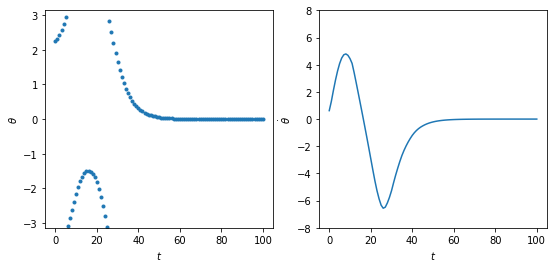

In [593]:
z1, z2 = bo.res['max']['max_params'].values()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
z = np.zeros(8)
z[0] = z1
z[3] = z2
z = torch.cuda.FloatTensor(z.reshape(1, -1))
Rs = []
#np.random.seed(0)
for _ in range(1):
    env.reset()
    obs = env.env.state = (2 * np.random.rand(2) - 1) * np.array([np.pi, 8.0])
    θs = [obs[0]]
    vs = [obs[1]]

    R = 0.0
    for t in range(100):
        x = x_pre(torch.cuda.FloatTensor(obs.reshape(1, -1))).cuda()
        env.state = np.array([np.pi, 0.0])
        u = policy(x, z)
        u_np = u.detach().cpu().numpy().flatten()
        obs, r, _, _ = env.step(u_np)
        env.render()
        θs.append(obs[0])
        vs.append(obs[1])
        R += r * gamma ** t
    ax1.plot(θs, '.')
    ax1.set_ylim(-np.pi, np.pi)
    ax1.set_ylabel('$θ$')
    ax1.set_xlabel('$t$')
    ax2.plot(vs)
    ax2.set_ylim(-8, 8)
    ax2.set_ylabel('$\dot{θ}$')
    ax2.set_xlabel('$t$')
    Rs.append(R)
plt.show()

In [11]:
masses = []
coeffs = []
for i, env in enumerate(envs.envs):
    masses.append((env.env.m, i))
    coeffs.append((env.env.action_cost, i))
z1s_m = []
z2s_m = []
ms = []
for m, i in sorted(masses):
    z1 = latent_mapping.mean[i, 0].cpu().detach().numpy()
    z2 = latent_mapping.mean[i, 3].cpu().detach().numpy()
    z1s_m.append(z1)
    z2s_m.append(z2)
    ms.append(m)
z1s_k = []
z2s_k = []
ks = []
for k, i in sorted(coeffs):
    z1 = latent_mapping.mean[i, 0].cpu().detach().numpy()
    z2 = latent_mapping.mean[i, 3].cpu().detach().numpy()
    z1s_k.append(z1)
    z2s_k.append(z2)
    ks.append(k)

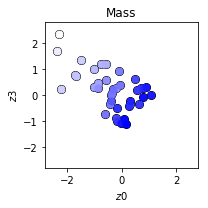

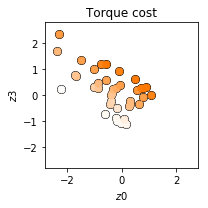

In [30]:
from matplotlib.colors import hsv_to_rgb

val_list = ms

def plot_foo(z1s, z2s, val_list, ax, hue=0):
    for z1, z2, v in zip(z1s, z2s, val_list):
        sat = (v - min(val_list)) / (max(val_list) - min(val_list))
        ax.plot(z1, z2, 'k.', markersize=16)
    for z1, z2, v in zip(z1s, z2s, val_list):
        sat = (v - min(val_list)) / (max(val_list) - min(val_list))
        ax.plot(z1, z2, '.', color=hsv_to_rgb((hue / 255, sat, 1.0)), markersize=14)
    ax.set_xlim(-2.8, 2.8)
    ax.set_ylim(-2.8, 2.8)
    ax.set_xlabel('$z0$')
    ax.set_ylabel('$z3$')

fig, ax = plt.subplots(figsize=(3, 3))
plot_foo(z1s_m, np.array(z2s_m), ms, ax, hue=170)
ax.set_title('Mass')
plt.tight_layout()
plt.savefig('/home/isacar/workspace/icra2019/figures/pendulum_latent_mass_2d.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
plot_foo(z1s_k, np.array(z2s_k), ks, ax, hue=20)
ax.set_title('Torque cost')
plt.tight_layout()
plt.savefig('/home/isacar/workspace/icra2019/figures/pendulum_latent_torque_2d.pdf')
plt.show()

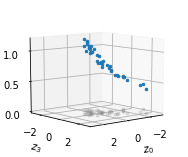

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(z1s_m, z2s_m, ms, '.', markersize=5.0)
ax.plot(z1s_m, z2s_m, np.zeros(len(ms)), '.', color='grey', alpha=0.2)
ax.set_xlabel('$z_0$')
ax.set_ylabel('$z_3$')
ax.set_zlabel('$m$')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_zticks([0.0, 0.5, 1.0])
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.view_init(elev=10, azim=50)
plt.show()

<IPython.core.display.Javascript object>


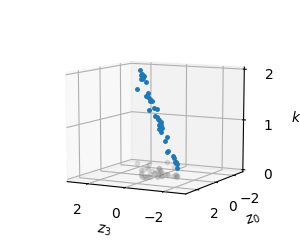

In [40]:
fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z2s_k, z1s_k, ks, '.', markersize=5.0)
ax.plot(z2s_k, z1s_k, np.zeros(len(ms)), '.', color='grey', alpha=0.2)
ax.set_xlabel('$z_3$')
ax.set_ylabel('$z_0$')
ax.set_zlabel('$k$')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_zticks([0.0, 1.0, 2.0])
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.view_init(elev=10, azim=118)
plt.show()

0 0


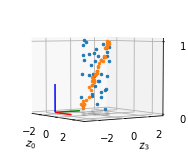

1 30


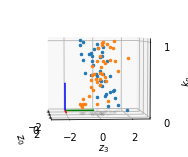

2 60


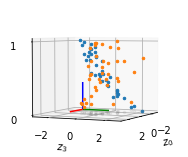

3 90


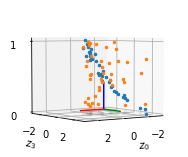

In [56]:
def plot(azimuth, filename=None):
    fig = plt.figure(figsize=(3, 2.5))
    #fig = plt.figure(figsize=(9, 7.5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(z1s_m, z2s_m, (np.array(ms) - 0.4) * 1.3, '.', markersize=5.0)
    ax.plot(z1s_k, z2s_k, np.array(ks) * 0.5, '.', markersize=5.0)
    ax.plot(z1s_k, z2s_k, np.zeros(len(ms)), '.', color='grey', alpha=0.1, markersize=5.0)
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_3$')
    ax.set_zlabel('$k_n$')
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    ax.set_zticks([0.0, 1.0])
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.view_init(elev=4, azim=-35 + azimuth)
    ax.quiver(-2, -2, 0, 2, 0, 0, arrow_length_ratio=0.0, color='red')
    ax.quiver(-2, -2, 0, 0, 2, 0, arrow_length_ratio=0.0, color='green')
    ax.quiver(-2, -2, 0, 0, 0, 0.4, arrow_length_ratio=0.0, color='blue')
    ax.grid(True)
    ax.axis('on')
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
for ind, i in enumerate([0, 30, 60, 90]):
    print(ind, i)
    #plot(i)
    plot(i)

In [42]:
env = envs_test.envs[3].env
env